# 5.3 전이 학습

## 특성 추출 기법

In [1]:
# 필요한 라이브러리 설치
!pip install opencv-python

### 라이브러리 호출

In [2]:
import os
import time
import copy
import glob
import cv2  #앞에서 설치한 openCV 라이브러리
import shutil

import torch
import torchvision  #컴퓨터 비전(computer vision)용도의 패키지
import torchvision.transforms as transforms  #데이터 전처리를 위해 사용되는 패키지
import torchvision.models as models  #다양한 파이토치 네트워크를 사용할 수 있도록 도와주는 패키지
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

### 이미지 데이터에 대한 전처리 방법 정의

In [6]:
data_path = '../content/drive/MyDrive/chap05/catanddog/train'  #이미지 데이터가 위치한 경로 지정
transform= transforms.Compose(
    [
        transforms.Resize([256, 256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
tran_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

385


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
#RandomResizedCrop 자세히 알아보기
!pip install mxnet
!pip install --user mxnet  #설치에 실패하면 --user 입력

In [15]:
!pip install --upgrade mxnet
!pip install numpy==1.19.5

  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.2
    Uninstalling numpy-2.1.2:
      Successfully uninstalled numpy-2.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 64.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for numpy (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for numpy
Failed to build numpy
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (numpy)


In [23]:
#RandomResizedCrop 데이터 확장 코드
import matplotlib.pyplot as plt

import numpy as np



In [29]:
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet.gluon.data.vision import transforms

/usr/local/lib/python3.10/dist-packages/mxnet/numpy/utils.py:37: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  bool = onp.bool


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [24]:

example_image = mx.image.imread("../content/drive/MyDrive/chap05/train/cat.jpg")

# 불러온 이미지 출력
plt.imshow(example_image.asnumpy())  # MXNet image to NumPy array
plt.axis('off')  # Optional: Turn off axis labels
plt.show()

NameError: name 'mx' is not defined

### randomResizedCrop 적용하기 위한 함수 생성

In [18]:
def show_images(imgs, num_rows, num_cols, scale=2):
    aspect_ratio = imgs[0].shape[0]/imgs[0].shape[1]  #확장할 이미지의 크기 조정
    figsize = (num_cols*scale, num_rows*scale*aspect_ratio)
    _, axes = plt.subplots(num_cols, figsize=figsize)
    for i in range(num_rows):
      for j in range(num_cols):
        axes[i][j].inshow(imgs[i*num_cols+ j].asnumpy())
        axes[i][j].axes.get_xaxis().set_visible(False)  #x축 전체를 숨김
        axes[i][j].axes.get_yaxis().set_visible(False)  #y축 전체를 숨김
    plt.subplots_adjust(hspace=0.1,wspace=0)
    return axes

def apply(img, aug, num_rows=2, num_cols=4, scale=3):
    Y =[aug(img) for _ in range(num_rows*num_cols)]  #다양한 샘플을 얻기 위해 여러 번 데이터 확장 적용
    show_images(Y, num_rows, num_cols, scale)

    #RandomResizedCrop이 적용되 이미지를 출력합니다.
    shape_aug = transforms.RandomResizedCrop(size = (200,200),
                                             scale=(0.1, 1),
                                             ratio=(0.5, 2))
    apply(example_image, shape_aug)

#이때 RandomResizedCrop에 적용된 파라미터는 다음과 같습니다.
shape_aug = transforms.RandomResizedCrop(size=(200, 200),
                                         scale=(0.1, 1),
                                         ratio=(0.5, 2))

### 학습에 사용될 이미지 출력

In [32]:

data_path = '../content/drive/MyDrive/chap05/catanddog/train/'
transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

385


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


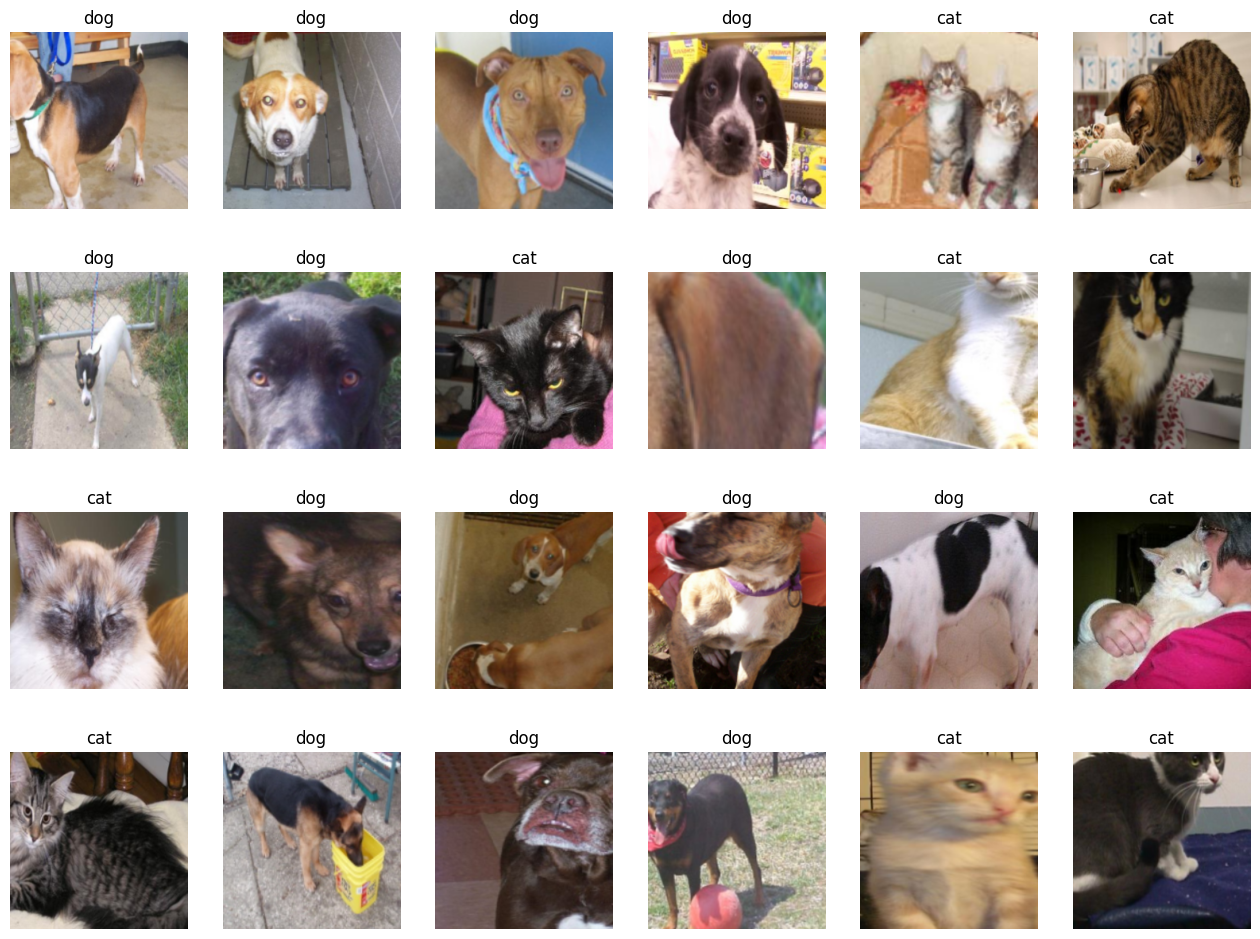

In [49]:
import numpy as np
samples, labels = next(iter(train_loader))
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [50]:
#변환

exam = np.arrange(24).reshape(2,3,4)
exam

np.transpose(exam, (2,1,0))

#사전 훈련된 모델 내려받기
resnet18 = models.resnet18(pretained=True)  #pretrained=True는 사전 학습된 가중치를 사용하겠다는 의미

AttributeError: module 'numpy' has no attribute 'arrange'

### 사전 훈련된 모델

In [51]:
import torchvision.models as models
resnet18 = models.resnet18()
alexnet = models.alexnet()
vgg16 = models.vgg16()
squeezenet = models.squeezenet1_0()
densenet = models.densenet161()
inception = models.inception_v3()
googlenet = models.googlenet()
shufflenet = models.shufflenet_v2_x1_0()
mobilenet_v2 = models.mobilenet_v2()
mobilenet_v3_large = mobilenet_v3_large()
mobilenet_v3_small = models.mobilenet_v3_small()
resnext50_32x4d = models.resnext50_32x4d()
wide_resnet50_2 =models.wide_resnet50_2()
mnasnet = models.mnasnet1_0()

NameError: name 'mobilenet_v3_large' is not defined

### 사전 학습된 모델(사전 학습된 모델의 가중치 값)을 사용

In [57]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained= True)
alexnet = models.alexnet(pretrained = True)
squeezenet = models.squeezenet1_0(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
densnet = models.densenet161(pretrained= True)
inception = models.inception_v3(pretrained = True)
googlenet = models.googlenet(pretrained=True)
shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
mobilenet_v2 = models.mobilenet_v2(pretrained=True)
mobilenet_v3_large = models.mobilenet_v3_large(pretrained=True)
mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)

resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
wide_resnet50_2 =models.wide_resnet50_2(pretrained = True)
mnasnet = models.mnasnet1_0(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 179MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-da

### 사전 훈련된 모델의 파라미터 학습 유무 지정

In [48]:
resnet18 = models.resnet18(pretrained=True)

In [37]:
def set_parameter_requires_grad(model, feature_extracting = True):
    if feature_extracting:
       for param in model.parameters():
           param.requires_grad = False

set_parameter_requires_grad(resnet18)

In [38]:
# Resnet18에 완전연결층 추가
resnet18.fc = nn.Linear(512, 2)  #2는 클래스가 두 개라는 의미

# 모델의 파라미터 값 확인
for name, param in resnet18.named_parameters():  #model.named_parameters()는 모델에 접근하여 파라미터 값들을 가져올 때 사용
    if param.requires_grad:
        print(name, param.data)

# 모델 객체 생성 및 손실 함수 정의
model = models.resnet18(pretrained=True)  #모델의 객체 생성

for param in model.parameters():  #모델의 합성곱층 가중치 고정
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():  #완전연결층은 학습
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()  #손실 함수 정의
print(model)

fc.weight tensor([[-0.0259,  0.0092,  0.0269,  ...,  0.0143,  0.0064,  0.0271],
        [ 0.0157,  0.0176, -0.0410,  ...,  0.0318,  0.0105,  0.0316]])
fc.bias tensor([-0.0340,  0.0078])
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kerne

### 모델 학습을 위한 함수 생성

In [43]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs = 13,
                is_trained=True):
    since = time.time()  #컴퓨터의 현재 시각을 구하는 함수
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(cum_epochs):  #에포크(13)만큼 반복
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:  #데이터로더에 전달된 데이터만틈 반복
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zere_grad()  #기울기를 0으로 설정
            outputs = model(inputs)  #순전파 학습
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()  #역전파 학습
            optimizer.step()

            running_loss += loss.item()* inputs.size(0)  #출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
            running_corrects += torch.sum(preds == labels.data)  #출력 결과와 레이블이 동일한지 확인한 결과를 누적하여 저장

        epoch_loss = running_loss / len(dataloaders.dataset)  #평균 오차 계산
        epoch_acc = running_corrects.double()/ len(dataloaders.dataset)  #평균 정확도 계산

        print('Loss: {:. 4f} Acc: {:. 4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc :
            best_acc > epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('../chap05/data/catanddog/',
                                                        '{0:0=2d}.pth'.format(epoch)))  #모델 재사용을 위해 저장해 둡니다.
        print()

    time_elapsed = time.time() - since  #실행 시간(학습 시간)을 계산
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                            time_elapsed % 60))
    print('Best Acc:{:4f}'.format(best_acc))
    return acc_history, loss_history  #모델의 정확도와 오차를 반환

### 파라미터 학습 결과를 옵티마이저에 전달

In [45]:
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)  #파라미터 학습 결과를 저장
        print('\t', name)

optimizer = optim.Adam(params_to_update)  #학습 결과를 옵티마이저에 전달

	 fc.weight
	 fc.bias


### 모델 학습

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

NameError: name 'cum_epochs' is not defined

### 테스트 데이터 호출 및 전처리

In [60]:
test_path = '../content/drive/MyDrive/chap05/catanddog/test'

transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


### 테스트 데이터 평가 함수 생성

In [61]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history  #계산된 정확도 반환

In [62]:
#테스트 데이터를 평가 함수에 적용
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model []
Validation complete in 0m 0s
Best Acc: 0.000000


### 훈련과 테스트 데이터의 정확도를 그래프로 확인

In [63]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

NameError: name 'train_acc_hist' is not defined

### 훈련 데이터의 오차에 대한 그래프 확인

In [64]:
plt.plot(train_loss_hist)
plt.show()

NameError: name 'train_loss_hist' is not defined

### 예측 이미지 출력을 위한 전처리 함수

In [65]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1,2,0)
    image = image * (np.array((0.5, 0.5, 0.5))+np.array((0.5,0.5,0.5)))
    image = image.clip(0,1)
    return image

### image 데이터를 0과 1사이의 값으로 제한하겠다는 예시

In [66]:
import numpy as np
exam = np.array([-1.8,-1.2, -0.7, 0.0, 0.8, 1.4, 1.9])
print(exam)
print(np.clip(exam,-0.1,0.5))

[-1.8 -1.2 -0.7  0.   0.8  1.4  1.9]
[-0.1 -0.1 -0.1  0.   0.5  0.5  0.5]


### 개와 고양이 예측 결과 출력

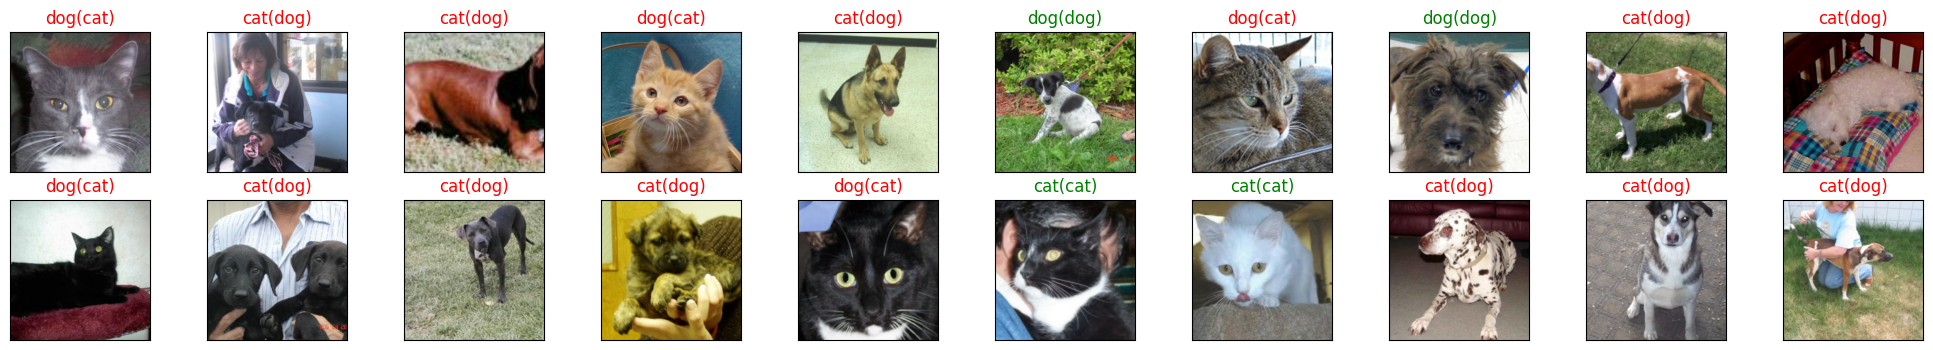

<Figure size 640x480 with 0 Axes>

In [68]:
classes = {0:'cat', 1:'dog'}

dataiter=iter(test_loader)
images,labels=next(dataiter)
output=model(images)
_,preds=torch.max(output,1)

fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[idx]))
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

## 특성 맵 시각화

In [69]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 설명 가능한 네트워크 생성

In [70]:
class XAI(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        return F.log_softmax(x)

### 모델 객체화

In [71]:
model=XAI()  #model이라는 이름의 객체를 생성
model.cpu()  #model을 장치(cpu 혹은 gpu)에 할당
model.eval()  #테스트 데이터에 대한 모델 평가 용도로 사용

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

### 특성 맵을 확인하기 위한 클래스 정의

In [72]:
class LayerActivations:
    features=[]
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        output = output
        #self.features = output.to(device).detach().numpy()
        self.features = output.detach().numpy()
    def remove(self):
        self.hook.remove()

### 네트워크 모듈의 입력 및 출력을 가져오는 예시

In [73]:
import torch
x=torch.Tensor([0,1,2,3]).requires_grad_()
y=torch.Tensor([4,5,6,7]).requires_grad_()
w=torch.Tensor([1,2,3,4]).requires_grad_()
z=x+y;
o=w.matmul(z)
o.backward()
print(x.grad, y.grad, z.grad, w.grad, o.grad)

tensor([1., 2., 3., 4.]) tensor([1., 2., 3., 4.]) None tensor([ 4.,  6.,  8., 10.]) None


<ipython-input-73-265238af1e3b>:8: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  print(x.grad, y.grad, z.grad, w.grad, o.grad)


### 이미지 호출

TypeError: Image data of dtype object cannot be converted to float

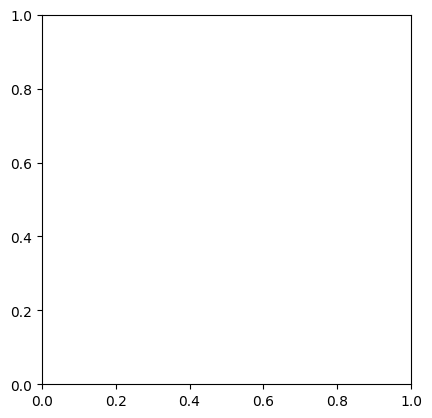

In [74]:
img=cv2.imread("cat.jpg")
plt.imshow(img)
img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_LINEAR)
img = ToTensor()(img).unsqueeze(0)

print(img.shape)

### unsqueeze 사용

In [76]:
import torch
x1 = torch.rand(3,10,64)
x2=x1.unsqueeze(dim=0)  #[3,10,64]->[1,3,10,64]
print(x2.shape)
print('----------')
x3=x1.unsqueeze(dim=1)  #[3,10,64]->[3,1,10,64]
print(x3.shape)

torch.Size([1, 3, 10, 64])
----------
torch.Size([3, 1, 10, 64])


### (0):Conv2d 특성 맵 확인

In [77]:
result = LayerActivations(model.features, 0)
model(img)
activations = result.features

TypeError: conv2d() received an invalid combination of arguments - got (NoneType, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)


### 특성 맵 확인

NameError: name 'activations' is not defined

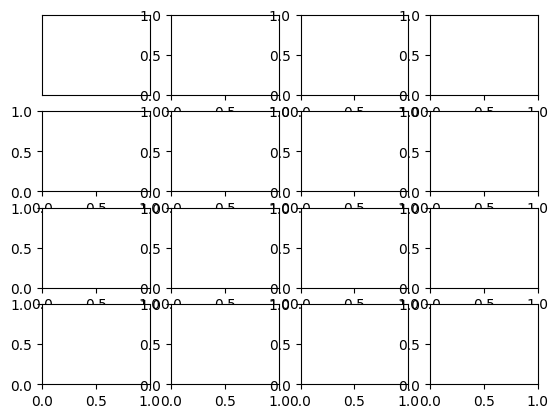

<Figure size 1200x800 with 0 Axes>

In [78]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

### 20번째 계층에 대한 특성 맵

In [79]:
result = LayerActivations(model.features, 20)

model(img)
activations = result.features

TypeError: conv2d() received an invalid combination of arguments - got (NoneType, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)


### 특성 맵 확인

NameError: name 'activations' is not defined

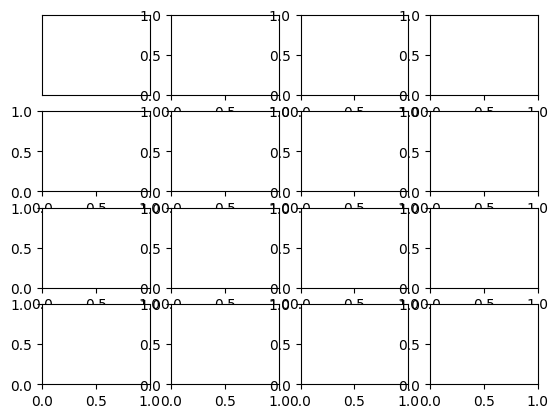

<Figure size 1200x800 with 0 Axes>

In [80]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

### 40번째 계층에 대한 특성 맵

In [ ]:
result = LayerActivations(model.features, 40)

model(img)
activations = result.features

### 특성 맵 확인

In [ ]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()